Tomaré como “dataset” el número medio de manchas solares por mes que ha habido desde 1749, lo voy a visualizar, y voy a aplicar una DNN para predecir valores futuros. Utilizaré TensorFlow de Google.

Extraido de la página web de donde saco los datos:

Número medio mensual total de manchas solares obtenido tomando una media aritmética simple del número diario total de manchas solares durante todos los días de cada mes calendario.

Problema de de regression supervised learning.

In [4]:
import tensorflow as tf #Cargamos 'tensorflow' para usarlo como 'tf'.
import numpy as np #Librería para computación científica. TensorFlow "bebe" de vectores que estén en numpy o usando Tensores propios de TensorFlow. 
import matplotlib.pyplot as plt #Librería estándar para mostrar gráficas.
import pandas as pd #Librería estándar para análisis y manipulación de datos en Python.
from sklearn.preprocessing import MinMaxScaler #Para escalar nuestros datos/features.
#Para que matplotlib sepa que estamos usando un Jupyter Notebook y nos permita interactuar con el gráfico.
%matplotlib inline

Descargo el archivo .csv de http://www.sidc.be/silso/INFO/snmtotcsv.php y lo defino en la variable SOURCE_DIR. 

In [5]:
SOURCE_DIR=r"C:\Users\meiza\Google Drive\Python\PycharmProjects\Blog"

Uso el método read_csv de pandas para leer los datos del archivo. 
El parámetro 'sep' sirve para decirle a pandas qué símbolo separa las columnas. 
'header=None' nos marca que el archivo .csv no tiene cabeceras.
Para que no  aparezca un aviso pasamos 'engine=python'.
Después uso el método 'head' para ver las primeras líneas del objeto dataset.

In [6]:
dataset = pd.read_csv(SOURCE_DIR+"\SN_m_tot_V2.0.csv", sep=";", header=None, engine='python')
dataset.head()

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


De la tabla anterior me interesa la columna '3', relativa a las manchas solares y me quedo con la columna '0' y '1'.
Uso  la función drop para quitar las columnas que no nos interesan.

In [7]:
dataset.drop([2, 4, 5, 6], inplace=True, axis=1)
dataset.columns = range(dataset.shape[1])
dataset.tail()

,0,1,2
3251,2019,12,1.5
3252,2020,1,6.4
3253,2020,2,0.4
3254,2020,3,1.5
3255,2020,4,5.4


Miramos si hay algun valor #N/A.

In [8]:
dataset.isna().sum()

0    0
1    0
2    0
dtype: int64

Ahora vamos a definir exactamente nuestra serie y  tiempo. Nuestra 'series' será la tercera columna de la tabla 'dataset', es decir, dataset[2]. Le pasamos la funcion np.array() para transformarlo a una matriz numpy, formato estándar para trabajar con TensorFlow. Para definir 'time' usamos la funcion de numpy 'arange' para que nos cree un listado desde '0' a 'len(series)'.

In [9]:
series = np.array(dataset[2])
time = np.arange(0, len(series))

Es hora de separar nuestros datos entre los que nos van a servir para entrenar el modelo, y los que van a validarlo. Normalmente se coge un 80% de los datos para entrenar, aunque en este caso al ser series temporales quizás queramos cambiarlo. Pongamos por ejemplo que existen ciclos de 11 años en las manchas solares, entonces para entrenar el modelo nos interesaría coger todo un ciclo, y quizás, esto es más (o menos) del 80%.

In [10]:
split = 0.8
split_time = int(split*len(series))
time_train= time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Estos valores no nos sirven para alimentar nuestro modelo, o mejor dicho, no son lo más óptimos. Antes de nada debemos escalarlos para que todos ellos estén entre 0 y 1. Definamos la función que lo hará y lo deshará y escalemos los datos.


In [11]:
escalar_train = MinMaxScaler()
escalar_valid = MinMaxScaler()

def escalar(train,valid):
    train = train.reshape(-1, 1)
    valid = valid.reshape(-1, 1)
    train_escal = escalar_train.fit_transform(train)
    valid_escal = escalar_valid.fit_transform(valid)
    train_escal = train_escal.squeeze()
    valid_escal = valid_escal.squeeze()
    return train_escal, valid_escal

def desescalar(train, valid):
    train = train.reshape(-1, 1)
    valid = valid.reshape(-1, 1)
    desescalar_train = escalar_train.inverse_transform(train)
    desescalar_valid = escalar_valid.inverse_transform(valid)
    desescalar_train = desescalar_train.squeeze()
    desescalar_valid = desescalar_train.squeeze()
    return desescalar_train, desescalar_valid
    
x_train_escal, x_valid_escal = escalar(x_train,x_valid)


A continuación vamos a graficar los datos. Para ello usaremos matplotlib.pyplot, la librería más habitual en Python para estas tareas. Primero marcamos el tamaño con la función 'figure' y el parámetro 'figsize'. Después definimos la etiqueta de los dos ejes y pasamos a 'plotear' x_train y x_valid.

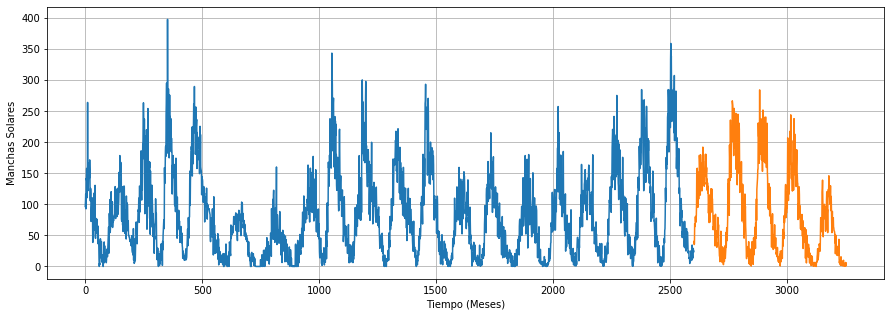

In [12]:
plt.figure(figsize=(15,5))
plt.xlabel("Tiempo (Meses)")
plt.ylabel("Manchas Solares")
plt.plot(time_train, x_train)
plt.plot(time_valid, x_valid)
plt.grid(True)

Vamos a crear una función que tome nuestros datos y los transforme en un formato con el cual podamos introducirlo al modelo.
1. Cogemos cada fila (en este caso es sólo un valor) y lo transformamos en un tensor usando tf.data.Dataset.from_tensor_slices.
2. Mediante ds.window vamos a agrupar los valores en grupos de 'window_size' para preparar el set con el que alimentar el modelo. Si por ejemplo definimos "window_size = 10", cogeremos grupos de 10 valores + 1 valor extra, este último será nuestro valor 'y', es decir, el que se usará para calcular el 'loss'. Con el parámetro shift, le decimos cuantos valores queremos saltar cada vez. Puede parecer complicado pero no lo es en absoluto. En https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window se explica perfectamente. Como comentario, el método window() devuelve un dataset que contiene las ventas, donde cada ventana es a su vez otro dataset.
3. El método flat_map() nos devuelve todos los tensores anidados en un dataset. Usamos el .batch para mantener las ventanas anteriores.
4. Mezclamos todos los tensores para evitar. El shuffle_buffer_size se usa para mezclar en lotes, en nuestro caso para los pocos valores que tenemos podemos poner 10.000 para mezclarlos todos a la vez sin problemas de memoria.
5. Mapeamos mediante ds.map separando entre W[:-1] (quitando nuestra 'y') y W[-1:] (hasta la 'y').
6. Por último formamos lotes de 'batch_size' y llamamos a prefetch para optimizar la carga de datos.

In [17]:
def window_datasheet(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    #for X, y in ds:
    #    print("Input:", X.numpy(), "Target:", y.numpy())
    return ds.batch(batch_size).prefetch(1)

Definimos los parámetros batch_size, window_size y shuffle_buffer, necesarios para la función que acabamos de crear. Una vez tengamos el modelo generado y entrenado podemos ajustar estos parámetros para ver si conseguimos mejora.

Después usamos la función creada anteriormente para crear nuestro set de entrenado para el modelo.

In [18]:
batch_size = 20
window_size = 30
shuffle_buffer = 10000

train_data = window_datasheet(x_train, window_size, batch_size, shuffle_buffer)


In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(150, input_shape=[window_size], activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [20]:

loss = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss,
              optimizer='adam',
              metrics=["mae"])
history = model.fit(train_data, epochs=30)

Epoch 1/30
129/129 [==============================] - 1s 9ms/step - loss: 22.9168 - mae: 22.9285
Epoch 2/30
129/129 [==============================] - ETA: 0s - loss: 18.5468 - mae: 18.546 - 0s 4ms/step - loss: 18.6036 - mae: 18.5941
Epoch 3/30
129/129 [==============================] - 1s 4ms/step - loss: 18.9144 - mae: 18.9100
Epoch 4/30
129/129 [==============================] - 0s 4ms/step - loss: 17.8911 - mae: 17.8892
Epoch 5/30
129/129 [==============================] - 1s 4ms/step - loss: 17.9485 - mae: 17.9564
Epoch 6/30
129/129 [==============================] - 0s 4ms/step - loss: 17.7485 - mae: 17.7677
Epoch 7/30
129/129 [==============================] - 0s 4ms/step - loss: 17.8843 - mae: 17.8802
Epoch 8/30
129/129 [==============================] - 0s 4ms/step - loss: 17.8875 - mae: 17.8963
Epoch 9/30
129/129 [==============================] - 0s 4ms/step - loss: 17.6663 - mae: 17.6465
Epoch 10/30
129/129 [==============================] - 0s 4ms/step - loss: 17.1824 - ma

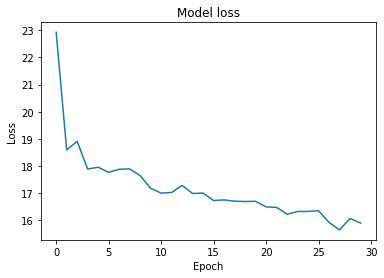

In [25]:
# Plotting loss values
plt.plot(history.history['loss'][:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

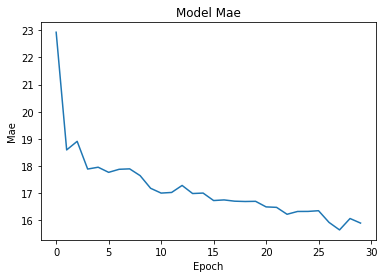

In [26]:
# Plotting mae values
plt.plot(history.history['mae'][:])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.show()

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
forecast = model_forecast(model, x_valid, window_size)
#rnn_forecast = rnn_forecast[split_time - window_size:-1]


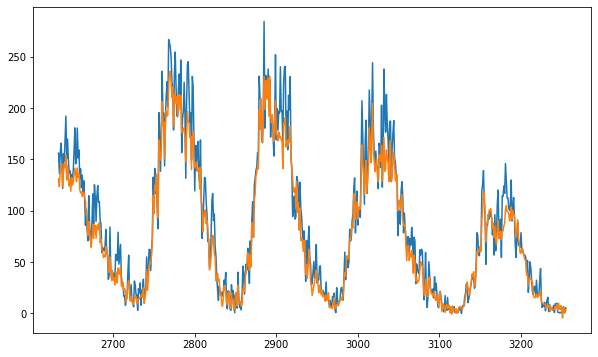

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid[window_size-1:], x_valid[window_size-1:])
plt.plot(time_valid[window_size-1:], forecast)
plt.show()

In [30]:
m = tf.keras.metrics.mean_absolute_error(x_valid[window_size:], forecast[window_size:]).numpy().mean()
print(m)

74.75191
